当我们说RNN的时候更多是指LSTM层，而不是RNN。

明确指上一章RNN时，会说简单RNN或者Elman

## 6.1 RNN的问题

上一章介绍的 RNN 之所以不擅长学习时序数据的长期依赖关系，是因为 BPTT 会发生梯度消失和梯度爆炸的问题。

### 6.1.1 RNN的复习

RNN层存在环路，如果展开它的循环，将变成一个在水平方向上延伸的网络

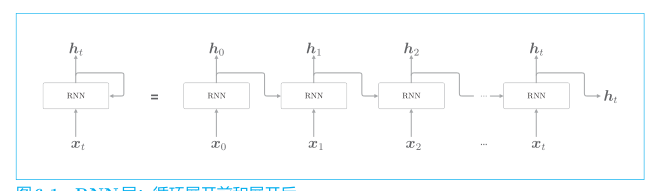

RNN层的特点在于使用了上一时刻的 隐藏状态，由此，RNN可以继承过去的信息

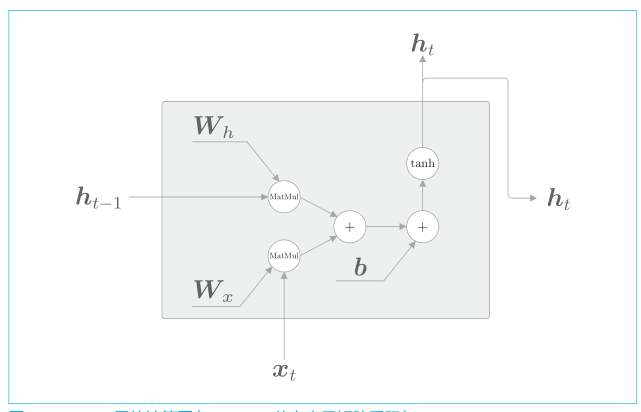

### 6.1.2 梯度消失和梯度爆炸

语言模型的任务是根据已经出现的单词预测下一个将要出现的单词

在反向传播的过程中，如果这个梯度在中途变弱（甚至没有包含任何信息），则权重参数将不会被更新。也就是说，RNN 层无法学习长期的依赖关系。不幸的是，随着时间的回溯，这个简单 RNN 未能避免梯度变小（梯度消失）或者梯度变大（梯度爆炸）的命运。

### 6.1.3 梯度消失和梯度爆炸的原因

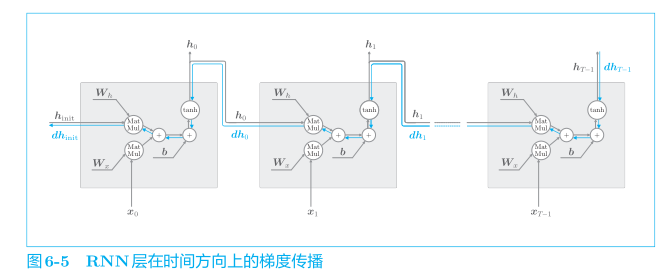

此时，关注时间方向上的梯度，可知反向传播的梯度流经 tanh、“+”和 MatMul（矩阵乘积）运算。

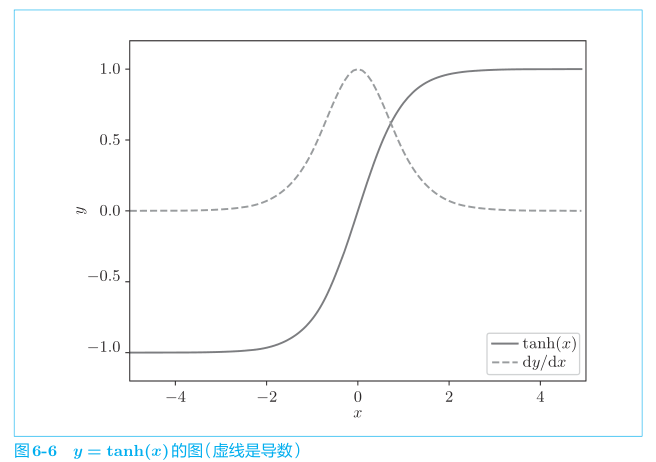

从图中可以看出，tanh导数的值小于1.0，并且随着 x 远离 0，它的值在变小。这意味着，当反向传播的梯度经过tanh 节点时，它的值会越来越小。因此，如果经过 tanh 函数 T 次，则梯度也会减小 T 次。

下面仅关注MatMul运算

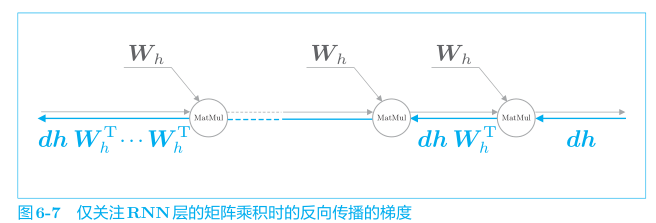

[2.4684068094579303, 3.3357049741610365, 4.783279375373182, 6.279587332087612, 8.080776465019053, 10.251163032292936, 12.936063506609896, 16.276861327786712, 20.45482961834598, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.8244073070191, 63.79612654485427, 80.07737014308985, 100.5129892205125, 126.16331847536823, 158.35920648258823, 198.7710796761195, 249.495615421267]


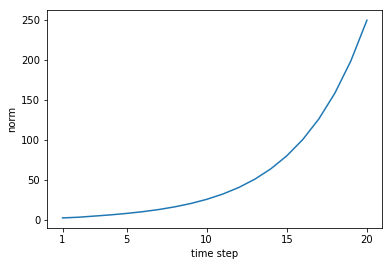

In [2]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


N = 2  # mini-batch的大小
H = 3  # 隐藏状态向量的维数
T = 20  # 时序数据的长度

dh = np.ones((N, H))

np.random.seed(3)

Wh = np.random.randn(H, H)
#Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

# 绘制图形
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()


可知梯度的大小随时间步长呈指数级增加，这就是梯度爆炸（exploding gradients）。如果发生梯度爆炸，最终就会导致溢出，出现NaN（Not a Number，非数值）之类的值。如此一来，神经网络的学习将无法正确运行。

而当把Wh的初始值改为

Wh = np.random.randh(H, h) * 0.5

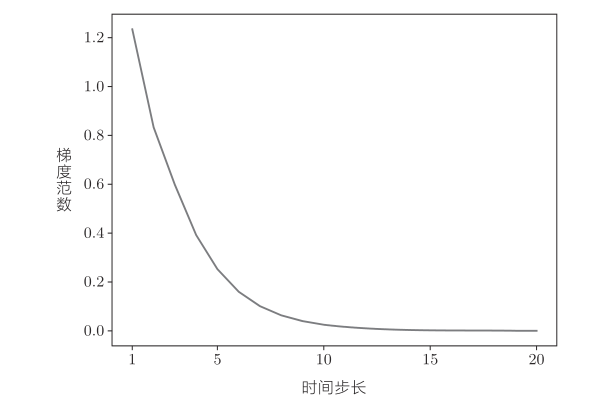

这次梯度呈指数级减小，这就是梯度消失（vanishing gradients）。如果发生梯度消失，梯度将迅速变小。一旦梯度变小，权重梯度不能被更新，模型就会无法学习长期的依赖关系。

**为什么会发生这种指数级变化呢，因为矩阵Wh被反复乘了T次。如果Wh是标量，则问题将很简单：当Wh大于 1 时，梯度呈指数级增加；当Wh小于 1 时，梯度呈指数级减小。**

**那么，如果Wh不是标量，而是矩阵呢？此时，矩阵的奇异值将成为指标。简单而言，矩阵的奇异值表示数据的离散程度。根据这个奇异值（更准确地说是多个奇异值中的最大值）是否大于 1，可以预测梯度大小的变化。**

如果奇异值的最大值大于 1，则可以预测梯度很有可能会呈指数级增加；而如果奇异值的最大值小于 1，则可以判断梯度会呈指数级减小。但是，并不是说奇异值比 1 大就一定会出现梯度爆炸。也就是说，这是必要条件，并非充分条件。

### 6.1.4 梯度爆炸的对策

#### 梯度裁剪 gradient clipping

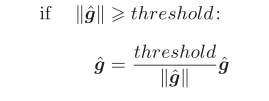

这里假设可以将神经网络用到的所有参数的梯度整合成一个，并用符号$\hat{g}$表示。另外，将阈值设置为 threshold。此时，如果梯度的 L2 范数$\lVert{\hat{g}}\rVert$大于或等于阈值，就按上述方法修正梯度，这就是梯度裁剪。如你所见，虽然这个方法很简单，但是在许多情况下效果都不错。

#### clip_grads

In [1]:
# coding: utf-8
import numpy as np


dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0


def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate


print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [7.24011983 8.73663135 3.34679407 7.85947088 4.46923372 0.51149056
 4.68648578 9.53080922 1.47612461]
after: [1.53276679 1.84958519 0.70853176 1.66388627 0.94615741 0.10828491
 0.99215068 2.01771631 0.31250239]


## 6.2 梯度消失和LSTM

### 6.2.1 LSTM的接口

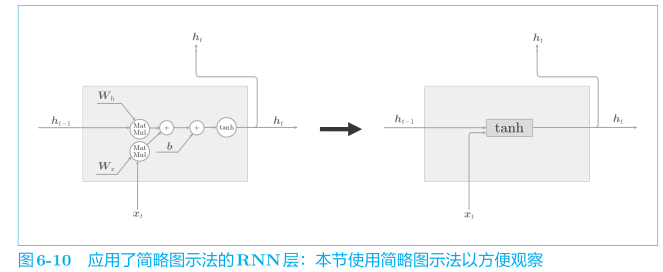

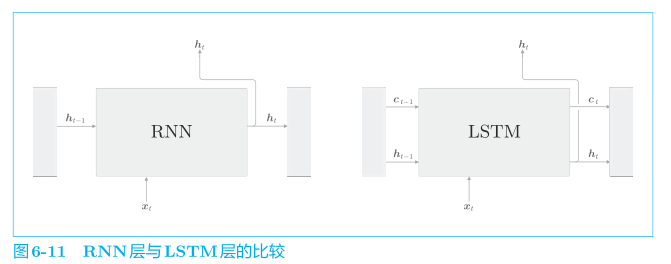

LSTM与RNN的不同之处在于LSTM还有路径c。c称为记忆单元，相当于LSTM专用的记忆单元

**记忆单元的特点是，仅在 LSTM 层内部接收和传递数据。也就是说，记忆单元在 LSTM 层内部结束工作，不向其他层输出。而 LSTM 的隐藏状态 h 和 RNN 层相同，会被（向上）输出到其他层。**

### 6.2.2 LSTM层的结构

$c_t$存储了时刻 t 时 LSTM 的记忆，可以认为其中保存了从过去到时刻 t 的所有必要信息（或者以此为目的进行了学习）。然后，基于这个充满必要信息的记忆，向外部的层（和下一时刻的 LSTM）输出隐藏状态 $h_t$

当前的记忆单元$c_t$是基于3个输入$c_{t-1},h_{t-1}$,和$x_t$经过某种计算的来的，这里的重点是隐藏状态 $h_t$要使用更新后的 $c_t$来计算。另外，这个计算是 $h_t= tanh(c_t)$，表示对 $c_t$的各个元素应用 tanh 函数。

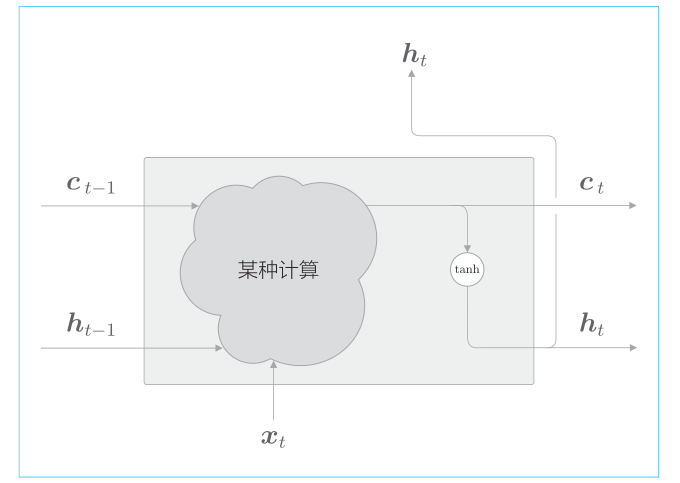

#### 开合程度

LSTM中的门并非只能开或者关，而是会有中间状态，可以控制开合程度。

有专门的权重参数用于控制门的开合程度，这些权重参数通过学习被更新。另外，sigmoid 函数用于求门的开合程度（sigmoid 函数的输出范围在 0.0 ~ 1.0）。

### 6.2.3 输出门（output gate）

刚才隐藏状态$\mathbf{h}_t$只是对记忆单元$c_t$应用了tanh函数。这里考虑对$tanh(c_t)$施加门。换句话说，针对 $tanh(c_t)$ 的各个元素，调整它们作为下一时刻的隐藏状态的重要程度。由于这个门管理下一个隐藏状态$ h_t$的输出，所以称为输出门（output gate）。

输出门的开合程度（流出比例）根据输入 xt和上一个状态 ht−1求出。

**这里在使用的权重参数和偏置的上标上添加了 output 的首字母 o。之后，我们也将使用上标表示门。**

sigmoid 函数用 σ() 表示

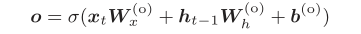

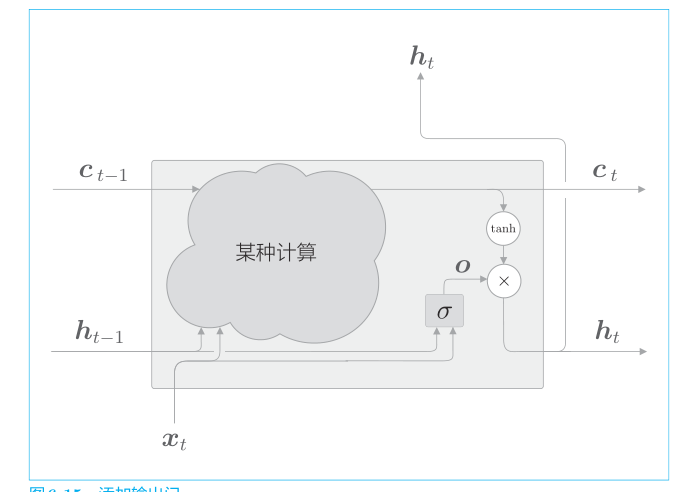

将输出门的计算表示为σ，然后，将它的输出表示为$\mathbf{o}$，则$h_t$由o和$tanh(c_t)$的乘积计算出来。乘积是对应元素的乘积，也成为阿达玛乘积（哈达玛乘积）。

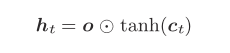

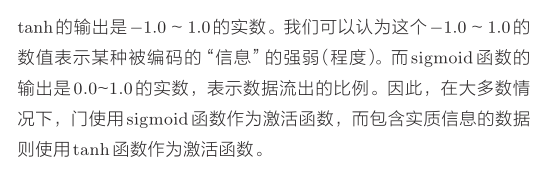

### 6.2.4 遗忘门 

在记忆单元$c_{t-1}$添加忘记不必要记忆的门，称为遗忘门。

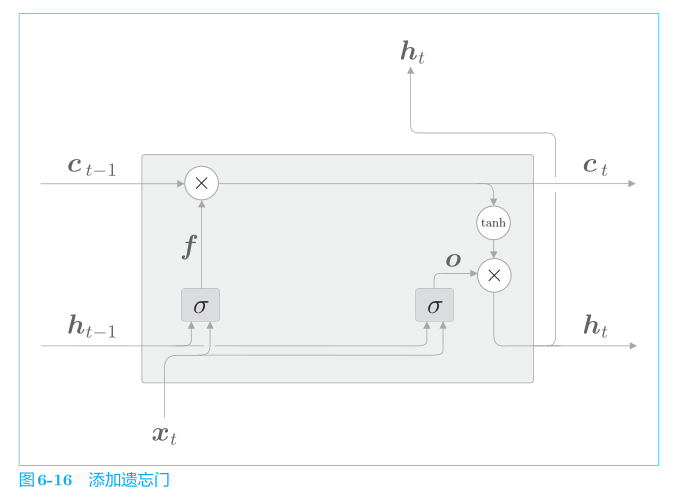

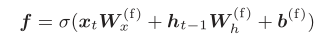

### 6.2.5 新的记忆单元

遗忘门会导致从上一时刻的记忆单元中删除了应该忘记的东西，但是这样，记忆单元只会忘记信息。还应该添加一些应当记住的新信息，为此增加新的tanh节点。

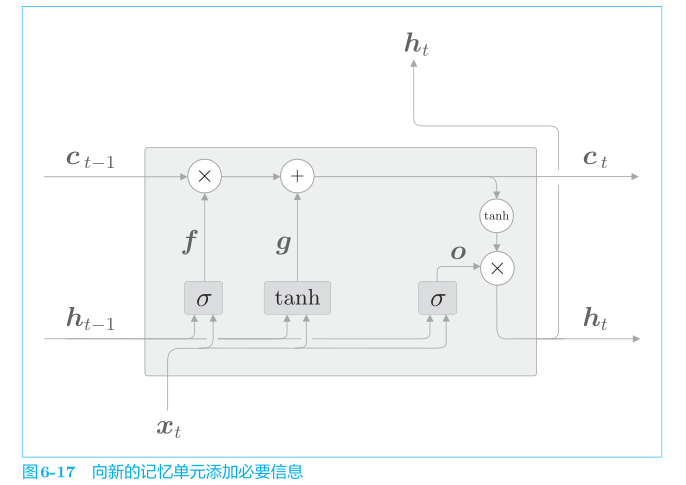

基于 tanh 节点计算出的结果被加到上一时刻的记忆单元 ct−1上。这样一来，新的信息就被添加到了记忆单元中。这个 tanh 节点的作用不是门，而是将新的信息添加到记忆单元中。因此，它不用 sigmoid函数作为激活函数，而是使用 tanh 函数。

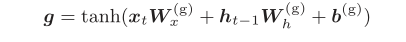

### 6.2.6 输入门

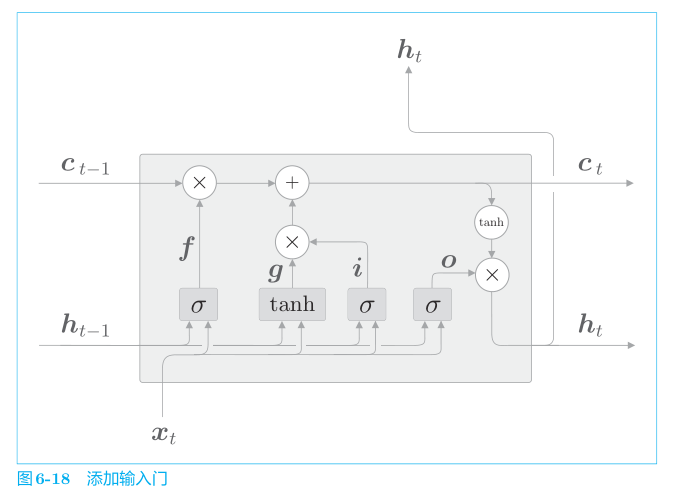

输入门判断新增信息 g 的各个元素的价值有多大。输入门不会不经考虑就添加新信息，而是会对要添加的信息进行取舍。换句话说，输入门会添加加权后的新信息。

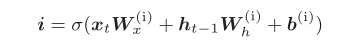

### 6.2.7 LSTM的梯度的流动

仅关注记忆单元的反向传播

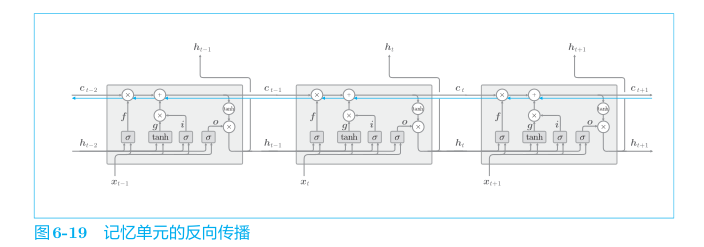

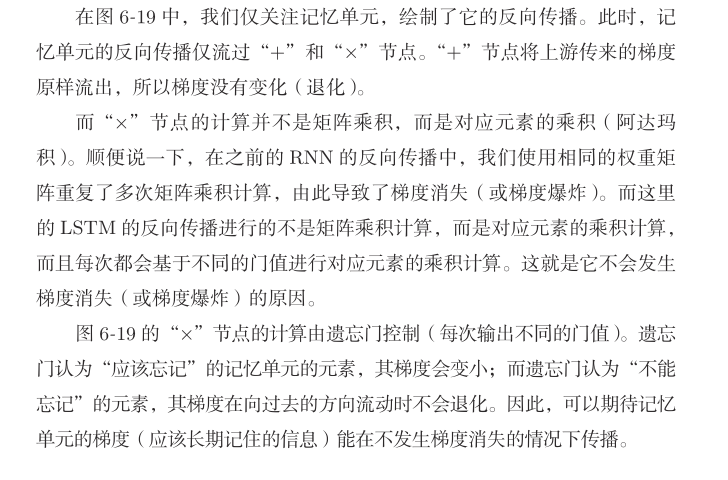

## 6.3 LSTM的实现

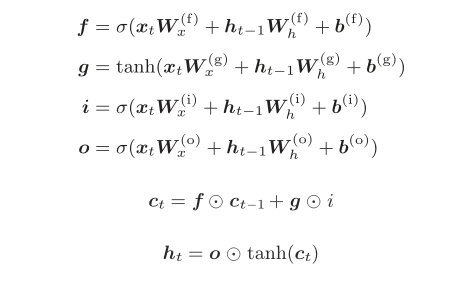

4个放射变换的式子可以整合成一个式子进行

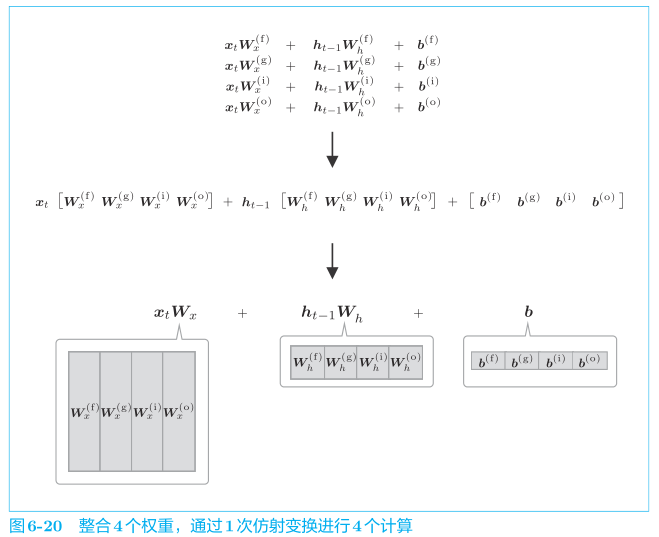

4 个权重（或偏置）被整合为了 1 个。如此，原本单独执行 4 次的仿射变换通过 1 次计算即可完成，可以加快计算速度。这是因为矩阵库计算“大矩阵”时通常会更快，而且通过将权重整合到一起管理，源代码也会更简洁。

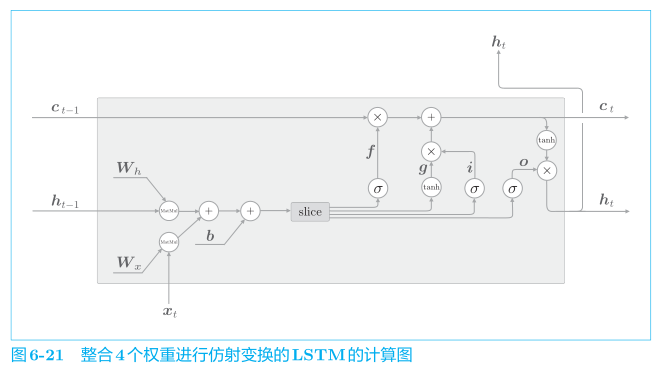

先一起执行 4 个仿射变换。然后，基于 slice 节点，取出 4 个结果。这个 slice 节点很简单，它将仿射变换的结果（矩阵）均等地分成 4 份，然后取出内容。

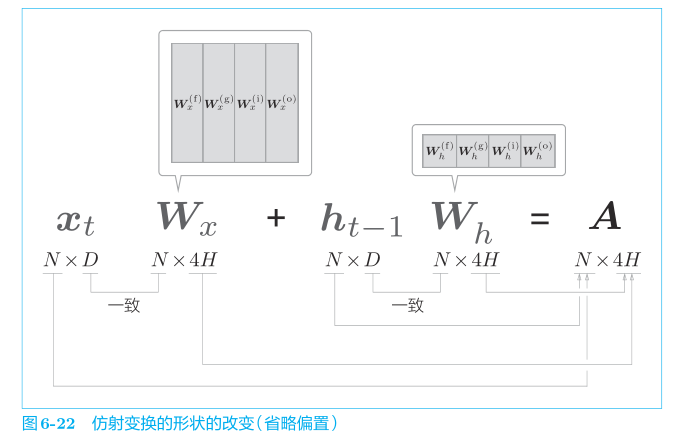

#### slice节点

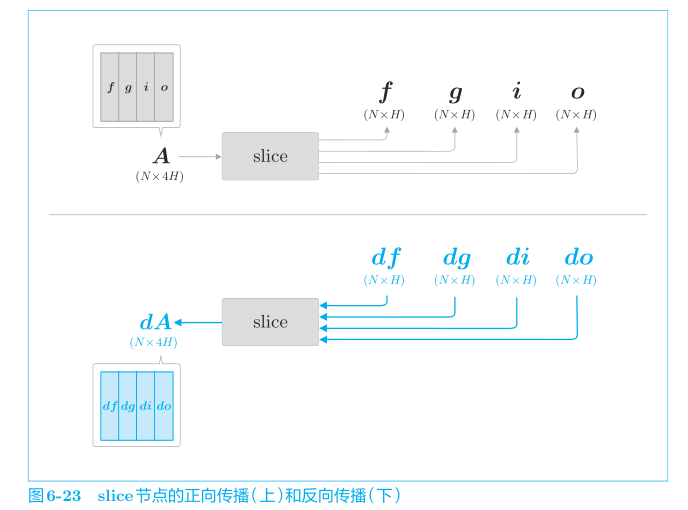

#### LSTM

In [ ]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        '''
        Parameters
        ----------
        Wx: 输入`x`用的权重参数（整合了4个权重）
        Wh: 隐藏状态`h`用的权重参数（整合了4个权重）
        b: 偏置（整合了4个偏置）
        '''
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

#### TIME LSTM

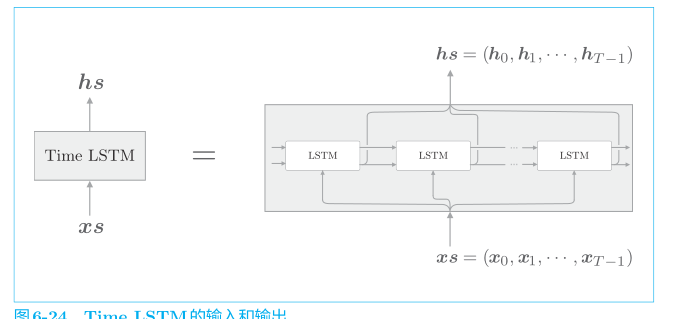

In [1]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

## 6.4 使用LSTM 的语言模型

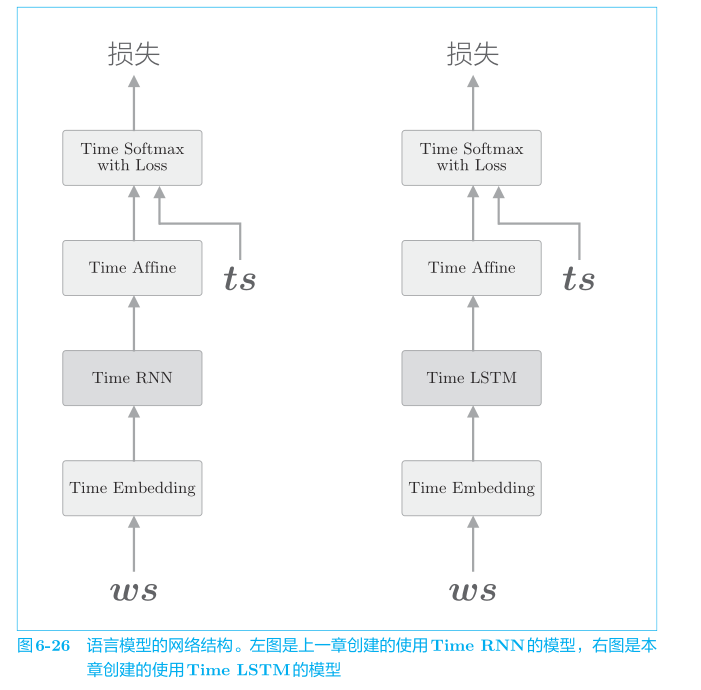

#### Rnnlm
见rnnlm

#### 使用rnnlm学习ptb数据

见train_rnnlm

但是模型的性能不是很好，困惑度缩小到了135左右。

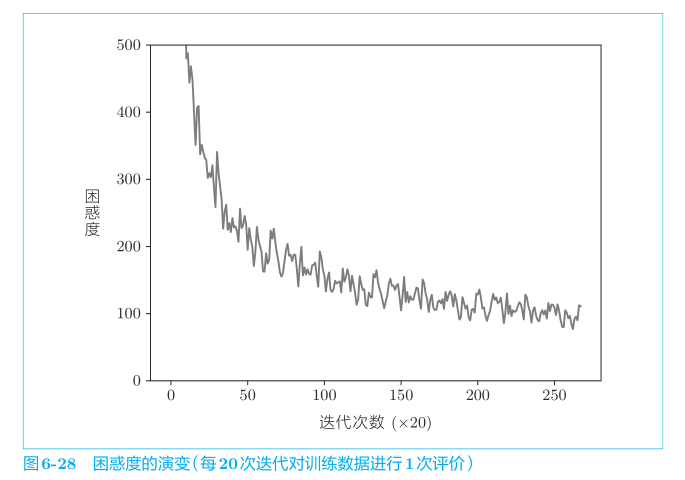

## 6.5 对rnnlm改进

### 6.5.1 LSTM的多层化

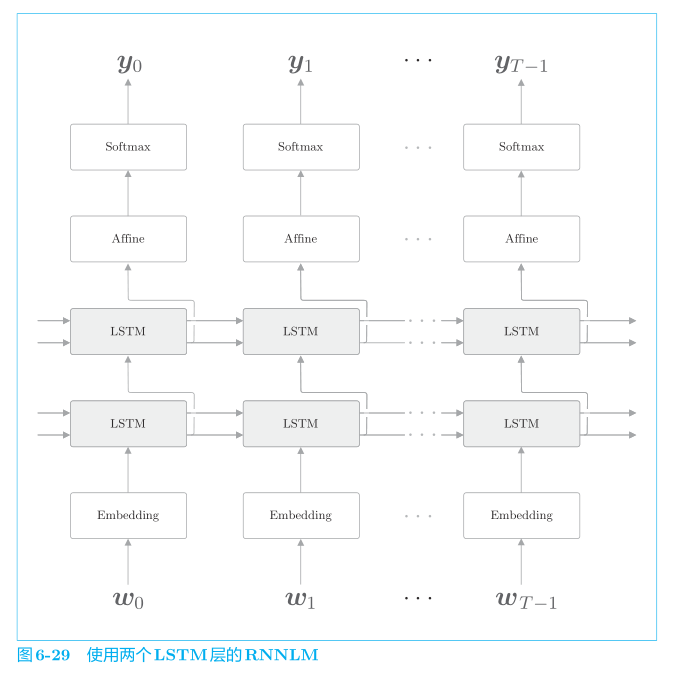

在 PTB 数据集上学习语言模型的情况下，当LSTM 的层数为 2 ～ 4 时，可以获得比较好的结果

### 6.5.2 基于Dropout防止过拟合

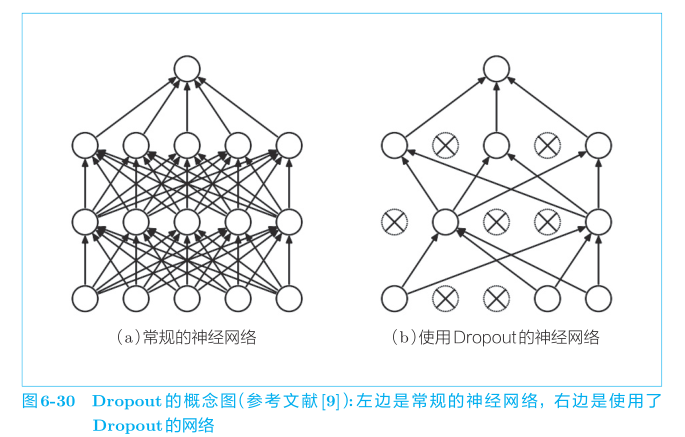

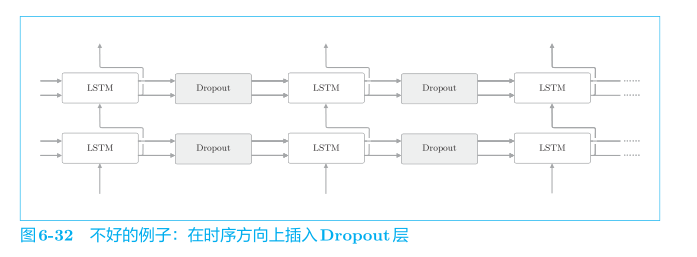

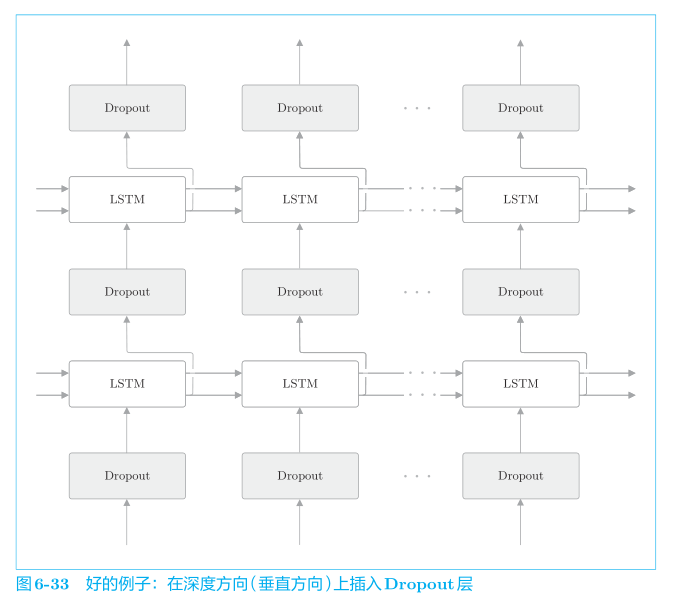

### 6.5.3 权重共享(weight tying)

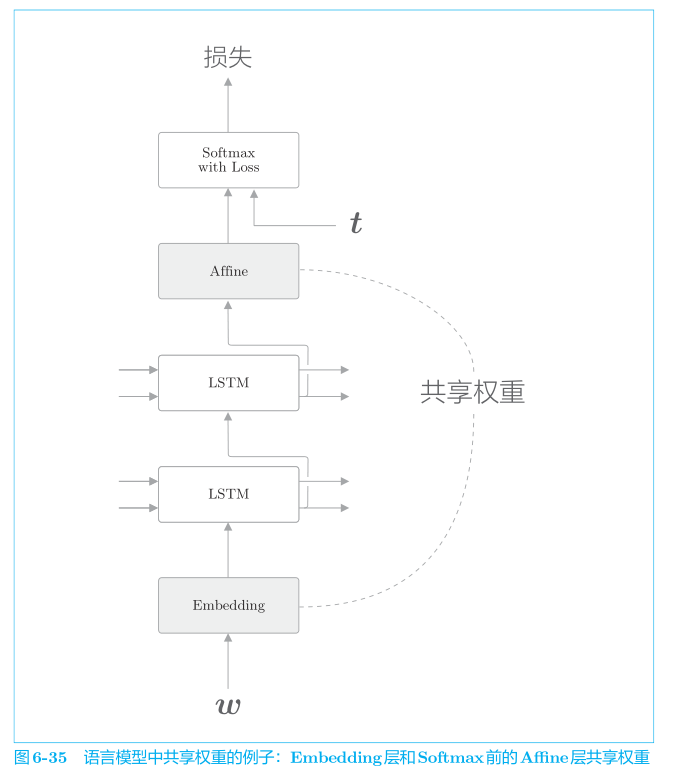

这里，假设词汇量为 V，LSTM 的隐藏状态的维数为 H，则 Embedding 层的权重形状为 V × H，Affine 层 的 权 重 形 状 为 H × V。 此 时， 如果要使用权重共享，只需将Embedding 层权重的转置设置为 Affine 层的权重。这个非常简单的技巧可以带来出色的结果。

但是为什么这里的Embedding层的权重是VxH，就是为了凑上权重的转置吗？

权重共享有效：https://arxiv.org/abs/1611.01462

### 6.5.4 更好的RNNLM的实现

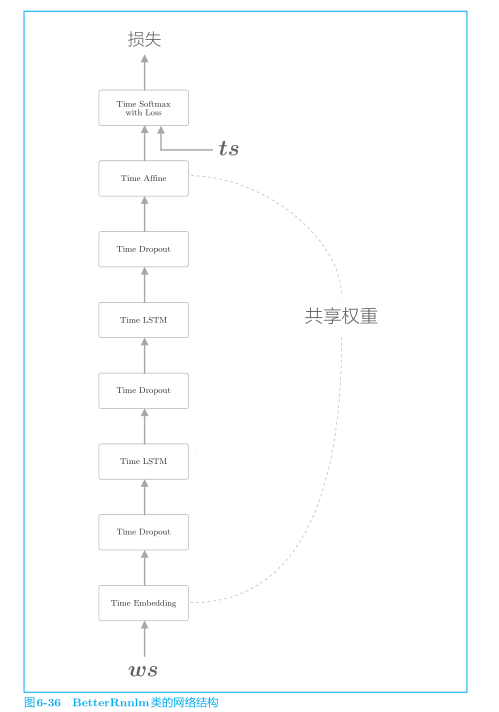

#### better_rnnlm
见better_rnnlm

#### train_better_rnnlm
见train_better_rnnlm

一个改动是针对每个epoch使用验证数据评价困惑度，在值变差时，降低学习率。